In [5]:
import sys , os
sys.path.append('../')

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import IPython.display as ipd
import soundfile as sf
import seaborn as sns
import pandas as pd
import mir_eval
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl

import dnn.bitwise_ss as bitwise_ss
import dnn.binary_layers as binary_layers
import dnn.bitwise_mlp as bitwise_mlp
import datasets.binary_data as binary_data
import datasets.quantized_data as quantized_data
from dnn.solvers import BinarySTFTSolver
import datasets.stft as stft
import datasets.utils as utils
import loss_and_metrics.bss_eval as bss_eval
import loss_and_metrics.visualize_settings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Binary Neural Network

In [20]:
my_stft = stft.STFT(nfft=1024, stride=256, win='hann')
my_istft = stft.ISTFT(nfft=1024, stride=256, win='hann')
torch_stft = lambda x : torch.stft(x, 1024, window=torch.hann_window(1024))
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

def get_audio_output(model, binary_sample, raw_sample, sampling_rate=16000):
    mix = raw_sample['mix']
    target = raw_sample['target']
    ipd.display(ipd.Audio(mix, rate=sampling_rate))
    ipd.display(ipd.Audio(target, rate=sampling_rate))
    mix = torch.FloatTensor(mix).unsqueeze(0)
    mag, phase = my_stft(mix)
    bmag = torch.FloatTensor(binary_sample['bmag']).unsqueeze(0)
    ibm = torch.FloatTensor(binary_sample['ibm']).numpy()
    model_in = bmag.permute(0, 2, 1).view(-1, bmag.size(1))
    premask = model(model_in)
    premask = premask.view(bmag.size(0), bmag.size(2), -1).permute(0, 2, 1)
    mask = binary_data.make_binary_mask(premask).to(torch.float)
    estimate = my_istft(mag * mask, phase).squeeze(1)
    ipd.display(ipd.Audio(estimate, rate=sampling_rate))
    mask = mask.squeeze(0).numpy()
    return mask, ibm

In [21]:
sample_rate = 8000
quantizer = quantized_data.Quantizer()
disperser = quantized_data.Disperser(4)
valset = utils.DatasetFromDirectory('/media/data/binary_audio/val', template='binary_data*.npz')
raw_valset = utils.DatasetFromDirectory('/media/data/binary_audio/val', template='raw_data*.npz')
testset = utils.DatasetFromDirectory('/media/data/binary_audio/test', template='binary_data*.npz')
raw_testset = utils.DatasetFromDirectory('/media/data/binary_audio/test', template='raw_data*.npz')
test_dl = DataLoader(testset, batch_size=16, shuffle=False)
raw_dl = DataLoader(raw_testset, batch_size=16, shuffle=False)
print('Number of Binary Validation Examples: ', len(valset))
print('Number of Binary Test Examples: ', len(testset))

bmag = valset[1]['bmag']
print(bmag.shape)
ibm = torch.FloatTensor(valset[1]['ibm'])
mix = raw_valset[1]['mix']
ipd.display(ipd.Audio(mix, rate=sample_rate))
spec = quantized_data.accumulate(bmag, quantizer, disperser)
mix_mag, mix_phase = my_stft(torch.FloatTensor(mix).unsqueeze(0))
torch_mix_mag, torch_mix_phase = torch_stft(torch.FloatTensor(mix).unsqueeze(0))
ideal = my_istft(mix_mag * ibm, mix_phase).squeeze(0)
ipd.display(ipd.Audio(ideal, rate=sample_rate))
print(ideal.size(), mix.shape)

time = np.arange(spec.shape[1]) / sample_rate
freqs = np.arange(spec.shape[0]) * 8000 / spec.shape[0]
plt.figure(figsize = (10, 10))
plt.subplot(311)
plt.pcolormesh(time, freqs, spec)
plt.colorbar()
plt.subplot(312)
plt.pcolormesh(time, freqs, mix_mag.squeeze(0))
plt.colorbar()
plt.subplot(313)
plt.pcolormesh(time, freqs, mix_mag.squeeze(0) * ibm)
plt.colorbar()

Number of Binary Validation Examples:  1440
Number of Binary Test Examples:  1440
(2052, 67)


ValueError: not enough values to unpack (expected 2, got 1)

## Bitwise Neural Network Evaluation

mlp_ss.model
Mean SDR:  7.726614952087402
Mean SIR:  18.970264434814453
Mean SAR:  8.484373092651367
Mean STOI:  0.8366652727127075


RuntimeError: Error(s) in loading state_dict for BitwiseMLP:
	Missing key(s) in state_dict: "out_bn.gamma". 
	Unexpected key(s) in state_dict: "filter_list.0.beta", "filter_list.1.w_binactiv.beta", "filter_list.2.w_binactiv.beta", "filter_list.3.w_binactiv.beta", "out_bn.weight", "out_bn.bias", "out_bn.running_mean", "out_bn.running_var", "out_bn.num_batches_tracked". 

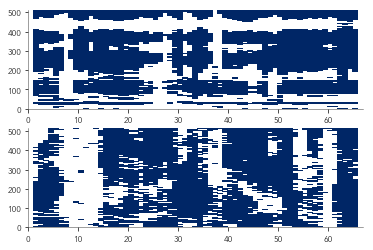

In [11]:
# Evaluate real source separation network
directory = '../models/'
models = ['mlp_ss.model', 'bmlp_ss.model']
in_binactiv_names = ['tanh', 'tanh_ste']
w_binactiv_names = ['tanh', 'tanh_ste']
metrics = []

for in_binactiv_name, w_binactiv_name, model in zip(in_binactiv_names, w_binactiv_names, models):
    in_binactiv = binary_layers.pick_activation(in_binactiv_name)
    w_binactiv = binary_layers.pick_activation(w_binactiv_name)
    mlp = bitwise_mlp.BitwiseMLP(2052, 513, fc_sizes=[2048, 2048, 2048], in_binactiv=in_binactiv, 
                                 w_binactiv=w_binactiv, bias=False)
    mlp.load_state_dict(torch.load(directory + model))
    solver = BinarySTFTSolver(mlp, F.binary_cross_entropy_with_logits)
    loss, met = solver.eval(test_dl, raw_dl)
    sdr, sir, sar, stoi = met.mean()
    metrics.append(met)
    mask, ibm = get_audio_output(mlp, testset[0], raw_testset[0], sampling_rate=8000)
    print(model)
    print('Mean SDR: ', sdr)
    print('Mean SIR: ', sir)
    print('Mean SAR: ', sar)
    print('Mean STOI: ', stoi)
    plt.figure()
    plt.subplot(211)
    plt.pcolormesh(mask)
    plt.subplot(212)
    plt.pcolormesh(ibm)
    

In [23]:
loss, met = solver.get_baseline(test_dl, raw_dl)
sdr, sir, sar, stoi = met.mean()
metrics.append(met)
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
print('Mean STOI: ', stoi)

Mean SDR:  13.465035438537598
Mean SIR:  29.213687896728516
Mean SAR:  13.618226051330566
Mean STOI:  0.9462083578109741


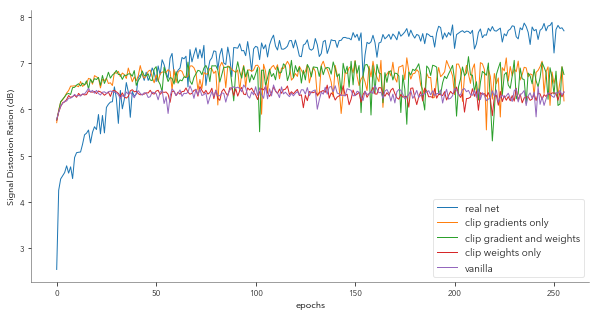

In [5]:
directory = '../results/'
data_files = ['net_tanh.pkl', 'net_nocw_cg_tanh.pkl', 'net_cw_cg_tanh.pkl', 'net_cw_nocg_tanh.pkl', 'net_nocw_nocg_tanh.pkl']
names = ['real net', 'clip gradients only', 'clip gradient and weights', 'clip weights only', 'vanilla']
curves = []

plt.figure(figsize=(10, 5))
for name, file in zip(names, data_files):
    with open(directory + file, 'rb') as f:
        data = pkl.load(f)
    curve, = plt.plot(data.sdrs, label=name)
    curves.append(curve)
plt.xlabel('epochs')
plt.ylabel('Signal Distortion Ration (dB)')
plt.legend(curves, names)

In [6]:
sdrs = np.stack([metrics[i].sdrs for i in range(len(metrics))], axis=1)
sirs = np.stack([metrics[i].sirs for i in range(len(metrics))], axis=1)
sars = np.stack([metrics[i].sars for i in range(len(metrics))], axis=1)
print(sdrs.shape)
names = ['full', 'binary']

(1440, 2)


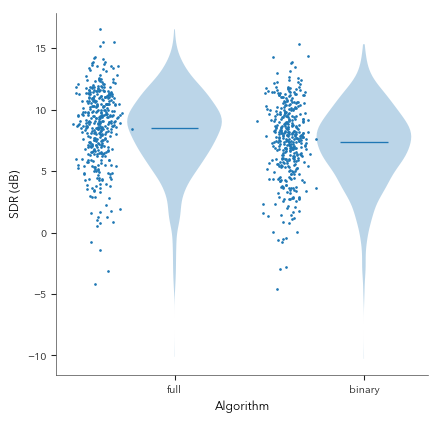

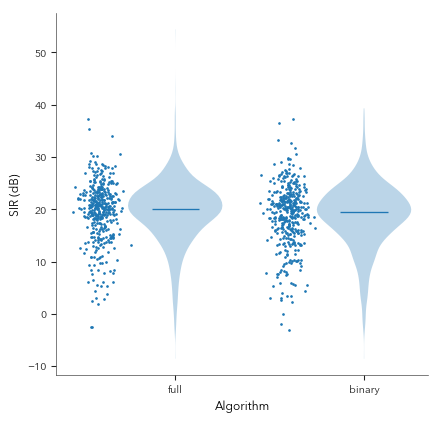

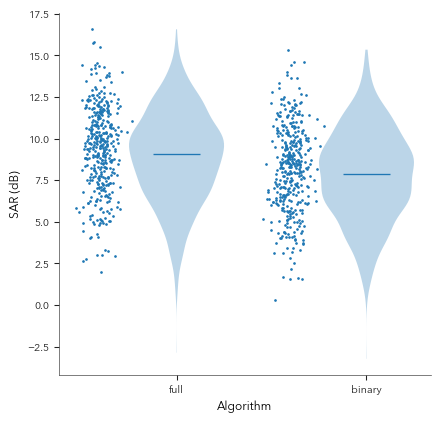

In [90]:
plt.figure(figsize=(5, 5))
plt.violinplot(sdrs, bw_method=.25, showmedians=True, showextrema=True)
plt.xticks(np.arange(1, len(names)+1), names)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sdrs[:400,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SDR (dB)')
plt.savefig('sdrs.png')

plt.figure(figsize=(5, 5))
plt.violinplot(sirs, bw_method=.25, showmedians=True, showextrema=True)
plt.xticks(np.arange(1, len(names)+1), names)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sirs[:400,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SIR (dB)')
plt.savefig('sirs.png')

plt.figure(figsize=(5, 5))
plt.violinplot(sars, bw_method=.25, showmedians=True, showextrema=True)
plt.xticks(np.arange(1, len(names)+1), names)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sars[:400,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SAR (dB)')
plt.savefig('sars.png')


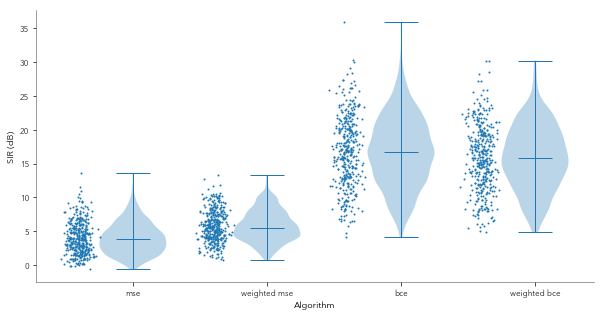

In [39]:
plt.figure(figsize=(10, 5))
plt.violinplot(sirs, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sirs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SIR (dB)')
plt.savefig('sirs.png')

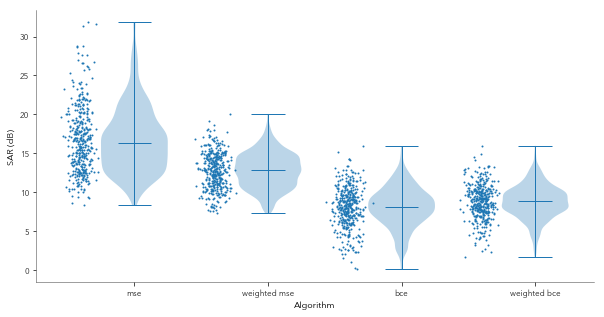

In [40]:
plt.figure(figsize=(10, 5))
plt.violinplot(sars, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sars[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SAR (dB)')
plt.savefig('sars.png')